In [1]:
from scipy.optimize import curve_fit
import pandas as pd
import random
import sys
from IPython.display import clear_output
from matplotlib import pyplot as plt

sys.path.append('../..')

from model import run
from model import plot_utils as pu
from model import processing
from model.amm.omnipool_amm import OmnipoolState, lrna_price
from model.amm.agents import Agent
from model.amm.trade_strategies import toxic_asset_attack
from model.amm.global_state import GlobalState

# Toxic asset attack

This exploit can occur when an attacker seizes full control of an asset traded on the omnipool, to the extent that they are able to mint an unlimited quantity of that asset. The attacker's strategy is to alternate between providing liquidity in the compromised token (up to the weight limit) and then selling some of the token into the pool in exchange for USD. The attack stops when the quantity of toxic asset in the pool reaches $10^{12}$, the maximum limit in omnipool. We'll examine how much USD the attacker is able to extract, and the effect of three different factors on that limit: trade size chosen by the attacker, the weight cap of the toxic asset, and the initial price of the asset.

In [2]:
# same seed, same parameters = same simulation result[[
random.seed(42)

assets = {
    'HDX': {'usd price': 0.005, 'weight': 0.10},
    'USD': {'usd price': 1, 'weight': 0.30},
    'ETH': {'usd price': 1000, 'weight': 0.50},
    'shitcoin': {'usd price': 1, 'weight': 0.10},
}

lrna_price_usd = 22
initial_omnipool_tvl = 10000000
liquidity = {}
lrna = {}

for tkn, info in assets.items():
    liquidity[tkn] = initial_omnipool_tvl * info['weight'] / info['usd price']
    lrna[tkn] = initial_omnipool_tvl * info['weight'] / lrna_price_usd

initial_state = GlobalState(
    pools={
        'omnipool': OmnipoolState(
            tokens={
                tkn: {'liquidity': liquidity[tkn], 'LRNA': lrna[tkn], 'weight_cap': max(assets[tkn]['weight'], 0.1)} for tkn in assets
            },
            lrna_fee=0,
            asset_fee=0,
            # trade_limit_per_block=float('inf')
        )
    },
    agents={
        'Attacker': Agent(
            holdings={'USD': 0, 'shitcoin': float('inf')},
            trade_strategy=toxic_asset_attack(
                pool_id='omnipool',
                asset_name='shitcoin',
                trade_size=10000
            )
        )
    },
    external_market={tkn: assets[tkn]['usd price'] for tkn in assets}
)

runs = 25
time_steps = 400
trade_size_events = []
asset_price_events = []
weight_cap_events = []
trade_limit_events = []

trade_factor = 2000
for i in range(runs):
    clear_output(wait=True)
    print(f'Running simulation with trade size {trade_factor * (i + 1)}...  {int(i/runs * 100)}%')
    copy_state = initial_state.copy()
    copy_state.agents['Attacker'].trade_strategy = toxic_asset_attack(
        pool_id='omnipool', 
        asset_name='shitcoin',
        trade_size=trade_factor * (i + 1)
    )
    # print(copy_state)
    trade_size_events.append(run.run(copy_state, time_steps=time_steps, silent=True))
    
weight_factor = 0.9 / (runs - 1)
for i in range(runs):
    clear_output(wait=True)
    copy_state = initial_state.copy()
    copy_state.pools['omnipool'].weight_cap['shitcoin'] = 0.01 + weight_factor * i
    copy_state.pools['omnipool'].weight_cap['shitcoin'] = round(copy_state.pools['omnipool'].weight_cap['shitcoin'], 4)
    
    print(f"Running simulation with weight cap {copy_state.pools['omnipool'].weight_cap['shitcoin']}...  {int(i/runs * 100)}%")

    # print(copy_state)
    weight_cap_events.append(run.run(copy_state, time_steps=time_steps, silent=True))
    
asset_price_factor = 1.5
asset_price = []
for i in range(runs):
    clear_output(wait=True)
    copy_state = initial_state.copy()
    assets['shitcoin']['usd_price'] = asset_price_factor ** i
    copy_state.external_market['shitcoin'] = round(assets['shitcoin']['usd_price'], 1)
    copy_state.pools['omnipool'].lrna['shitcoin'] /= lrna_price(copy_state.pools['omnipool'], 'shitcoin')
    asset_price.append(copy_state.external_market['shitcoin'])
    
    
    print(f"Running simulation with asset price {copy_state.external_market['shitcoin']}...  {int(i/runs * 100)}%")

    # print(copy_state)
    asset_price_events.append(run.run(copy_state, time_steps=time_steps, silent=True))
    
trade_cap_factor = 0.9 / (runs - 1)
for i in range(runs):
    clear_output(wait=True)
    copy_state = initial_state.copy()
    copy_state.pools['omnipool'].trade_limit_per_block = 0.1 + trade_cap_factor * i
    
    print(f"Running simulation with per-block trade limit {round(copy_state.pools['omnipool'].trade_limit_per_block * 100, 1)}%...  {int(i/runs * 100)}%")

    # print(copy_state)
    trade_limit_events.append(run.run(copy_state, time_steps=time_steps, silent=True))

Running simulation with per-block trade limit 100.0%...  96%


In [3]:
%matplotlib inline


## Plotting attacker profits against trade size

One of the trade-offs the attacker can make is between trading in large chunks, to finish the attack quickly, or in smaller chunks, to minimize slippage and maximize profit. For this run, we'll vary the trade size from \\$2000 to \\$50,000.

Simulation parameters: <br>
weight cap: 10% <br>
asset price: 1 USD <br>
trade size: \\$2,000 - \\$50,000

Text(0, 0.5, 'attacker profit')

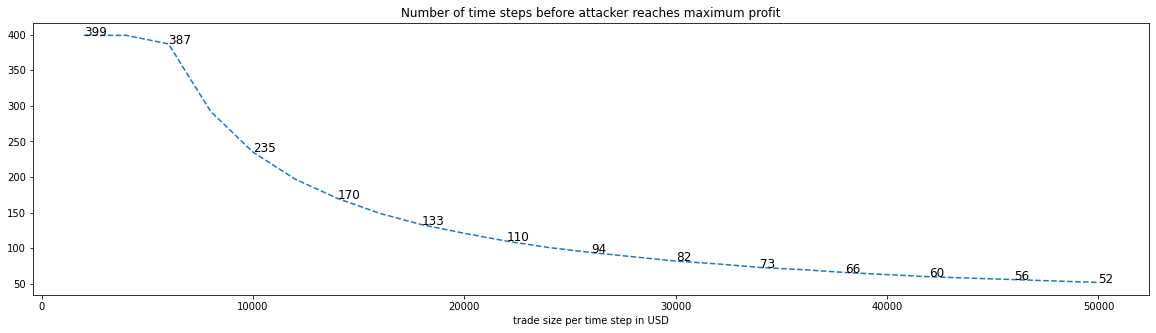

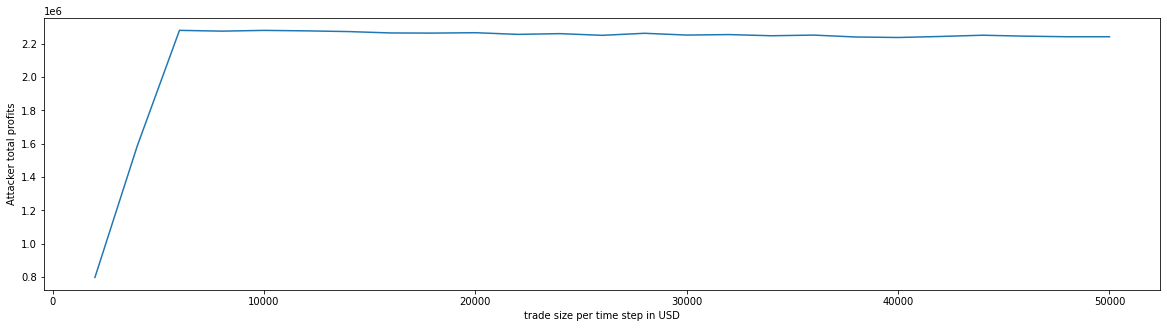

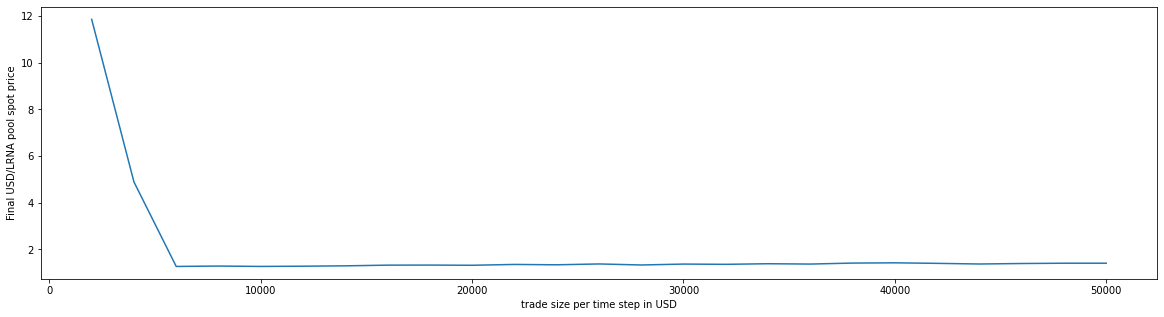

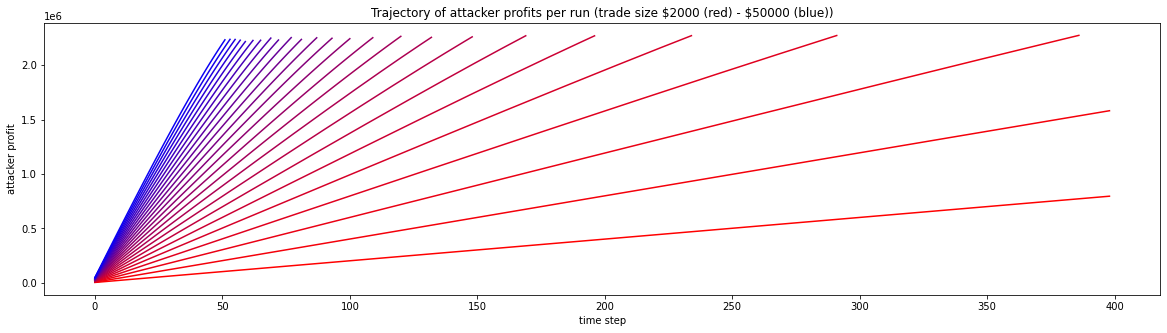

In [4]:
time_to_drain = []
for run in trade_size_events:
    end_state = run[-1].agents['Attacker'].holdings['USD']
    for n, event in enumerate(run):
        if event.agents['Attacker'].holdings['USD'] == end_state:
            time_to_drain.append(n)
            break

plt.figure(figsize=(20, 5))
ax = plt.subplot(111)
trade_sizes = [(1 + i) * trade_factor for i in range(runs)]
ax.plot(
    trade_sizes, 
    time_to_drain, 
    '--'
)
plt.title('Number of time steps before attacker reaches maximum profit')
plt.xlabel('trade size per time step in USD')
points = list(range(runs))[::int(runs/10)]
# plt.scatter([trade_factor * (i + 1) for i in points], [time_to_drain[i] for i in points])
for i in points:
    plt.text(trade_sizes[i], time_to_drain[i], time_to_drain[i], fontsize=12)
    
plt.figure(figsize=(20, 5))
ax = plt.subplot(111)
ax.plot(
    trade_sizes, 
    [run[-1].agents['Attacker'].holdings['USD'] for run in trade_size_events], 
)
plt.ylabel('Attacker total profits')
plt.xlabel('trade size per time step in USD')

plt.figure(figsize=(20, 5))
ax = plt.subplot(111)
ax.plot(
    trade_sizes, 
    [1/lrna_price(run[-1].pools['omnipool'], 'USD') for run in trade_size_events], 
)
plt.ylabel('Final USD/LRNA pool spot price')
plt.xlabel('trade size per time step in USD')

plt.figure(figsize=(20, 5))
colors = pu.color_gradient(runs)
for i, run in enumerate(trade_size_events):
    plt.plot(range(time_to_drain[i]), pu.get_datastream(run, agent='Attacker', prop='holdings', key='USD')[:time_to_drain[i]], color=colors[i])
plt.title(f'Trajectory of attacker profits per run (trade size \${trade_sizes[0]} (red) - \${trade_sizes[-1]} (blue))')
plt.xlabel('time step')
plt.ylabel('attacker profit')

## Plotting attacker profits against weight cap
Asset pools in omnipool are restricted by a per-asset weight limit: the liquidity in each pool (as measured in LRNA) can't exceed that percentage of the total. For this run, we'll vary the weight limit in the toxic asset from 1% to 10% of the total omnipool.

Simulation parameters: <br>
weight cap: 1% - 10% <br>
asset price: 1 USD <br>
trade size: \\$10,000

Text(0.5, 0, 'weight cap of toxic asset')

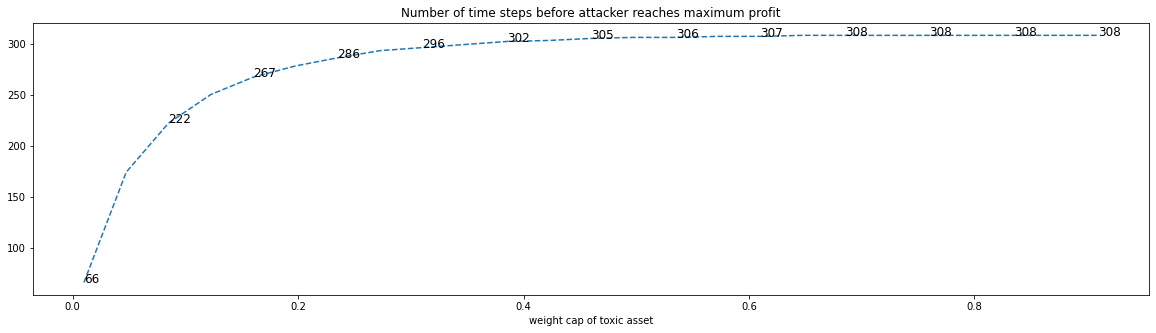

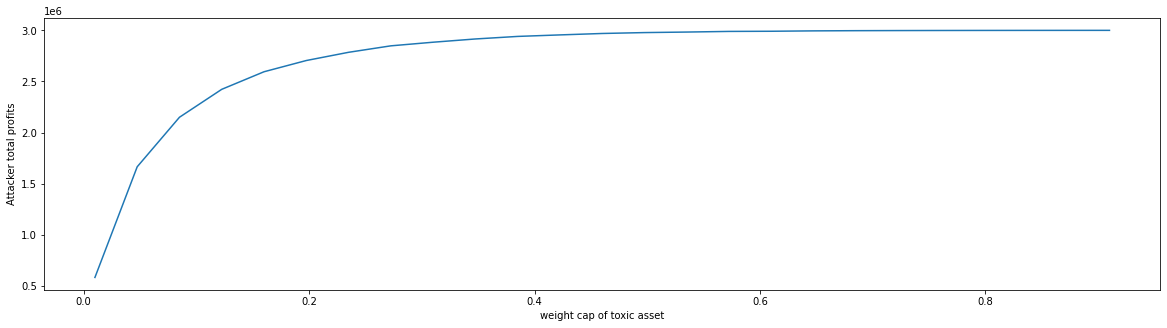

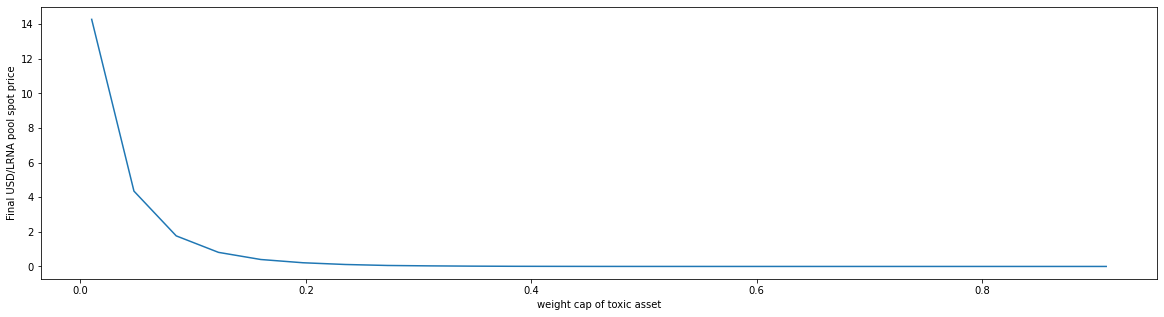

In [5]:
time_to_drain = []
for run in weight_cap_events:
    end_state = run[-1].agents['Attacker'].holdings['USD']
    for n, event in enumerate(run):
        if event.agents['Attacker'].holdings['USD'] == end_state:
            time_to_drain.append(n)
            break
weight_cap = [run[0].pools['omnipool'].weight_cap['shitcoin'] for run in weight_cap_events]

plt.figure(figsize=(20, 5))
ax = plt.subplot(111)
ax.plot(
    weight_cap, 
    time_to_drain, 
    '--'
)
plt.title('Number of time steps before attacker reaches maximum profit')
plt.xlabel('weight cap of toxic asset')
points = list(range(runs))[::int(runs/10)]
# plt.scatter([trade_factor * (i + 1) for i in points], [time_to_drain[i] for i in points])
for i in points:
    plt.text(weight_cap[i], time_to_drain[i], time_to_drain[i], fontsize=12)

plt.figure(figsize=(20, 5))
ax = plt.subplot(111)
ax.plot(
    weight_cap, 
    [run[-1].agents['Attacker'].holdings['USD'] for run in weight_cap_events], 
)
plt.ylabel('Attacker total profits')
plt.xlabel('weight cap of toxic asset')

plt.figure(figsize=(20, 5))
ax = plt.subplot(111)
ax.plot(
    weight_cap, 
    [1/lrna_price(run[-1].pools['omnipool'], 'USD') for run in weight_cap_events], 
)
plt.ylabel('Final USD/LRNA pool spot price')
plt.xlabel('weight cap of toxic asset')

## Plotting attacker profits against toxic asset price
Assets, of course, can have very different prices, and here we'll examine what effect the initial price of the toxic asset has on the profit the attacker is able to extract and the time it takes to do so.

Simulation parameters: <br>
weight cap: 10% <br>
asset price: 1 - 16,834 USD <br>
trade size: \\$10,000

TypeError: lrna_price() missing 1 required positional argument: 'i'

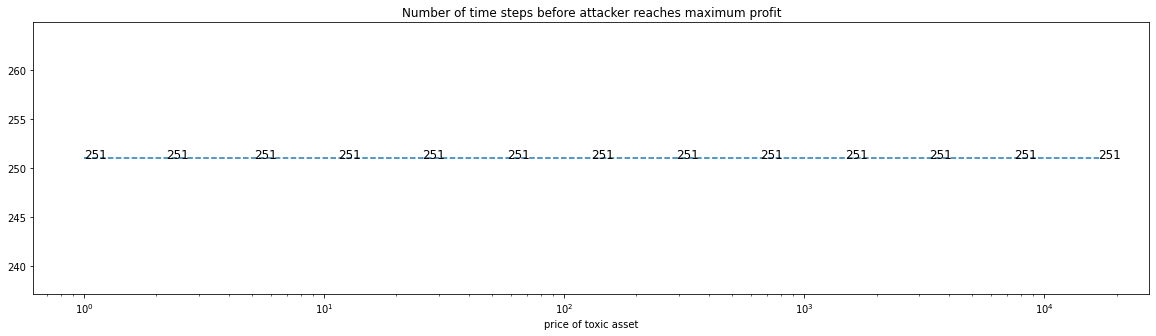

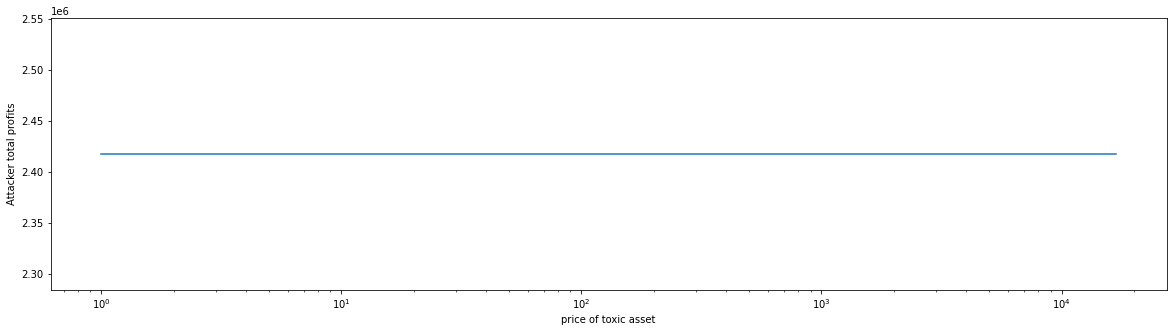

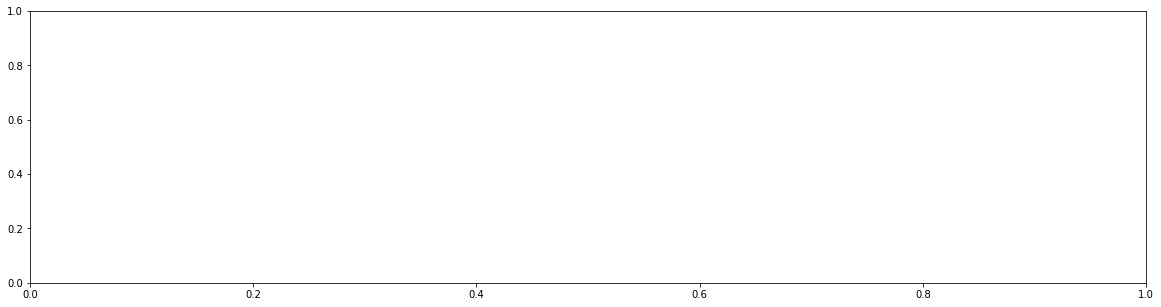

In [6]:
time_to_drain = []
for run in asset_price_events:
    end_state = run[-1].agents['Attacker'].holdings['USD']
    for n, event in enumerate(run):
        if event.agents['Attacker'].holdings['USD'] == end_state:
            time_to_drain.append(n)
            break
            
plt.figure(figsize=(20, 5))
ax = plt.subplot(111)
ax.plot(
    asset_price, 
    time_to_drain, 
    '--'
)
plt.title('Number of time steps before attacker reaches maximum profit')
plt.xlabel('price of toxic asset')
plt.xscale('log')
points = list(range(runs))[::int(runs/10)]
# plt.scatter([trade_factor * (i + 1) for i in points], [time_to_drain[i] for i in points])
for i in points:
    plt.text(asset_price[i], time_to_drain[i], time_to_drain[i], fontsize=12)

plt.figure(figsize=(20, 5))
ax = plt.subplot(111)
ax.plot(
    asset_price, 
    [run[-1].agents['Attacker'].holdings['USD'] for run in asset_price_events], 
)
plt.ylabel('Attacker total profits')
plt.xlabel('price of toxic asset')
plt.xscale('log')

plt.figure(figsize=(20, 5))
ax = plt.subplot(111)
ax.plot(
    asset_price, 
    [1/run[-1].pools['omnipool'].lrna_price('USD') for run in asset_price_events], 
)
plt.ylabel('Final USD/LRNA pool spot price')
plt.xlabel('price of toxic asset')
plt.xscale('log')
print(asset_price[-1])

## Plotting attacker profits against per-block trade limit
Assets, of course, can have very different prices, and here we'll examine what effect the initial price of the toxic asset has on the profit the attacker is able to extract and the time it takes to do so.

Simulation parameters: <br>
weight cap: 10% <br>
asset price: 1 USD <br>
trade size: \\$10,000
per-block trade limit: 10% - 100%

In [ ]:
time_to_drain = []
for run in trade_limit_events:
    end_state = run[-1].agents['Attacker'].holdings['USD']
    for n, event in enumerate(run):
        if event.agents['Attacker'].holdings['USD'] == end_state:
            time_to_drain.append(n)
            break
trade_limit = [run[0].pools['omnipool'].trade_limit_per_block * 100 for run in trade_limit_events]

plt.figure(figsize=(20, 5))
ax = plt.subplot(111)
ax.plot(
    trade_limit, 
    time_to_drain, 
    '--'
)
plt.title('Number of time steps before attacker reaches maximum profit')
plt.xlabel('percentage of the pool that can be traded per block')
points = list(range(runs))[::int(runs/10)]
# plt.scatter([trade_factor * (i + 1) for i in points], [time_to_drain[i] for i in points])
for i in points:
    plt.text(trade_limit[i], time_to_drain[i], time_to_drain[i], fontsize=12)

plt.figure(figsize=(20, 5))
ax = plt.subplot(111)
ax.plot(
    trade_limit, 
    [run[-1].agents['Attacker'].holdings['USD'] for run in trade_limit_events], 
)
plt.ylabel('Attacker total profits')
plt.xlabel('percentage of the pool that can be traded per block')

plt.figure(figsize=(20, 5))
ax = plt.subplot(111)
ax.plot(
    trade_limit, 
    [1/run[-1].pools['omnipool'].lrna_price('USD') for run in trade_limit_events], 
)
plt.ylabel('Final USD/LRNA pool spot price')
plt.xlabel('percentage of the pool that can be traded per block')
print(f"Weight cap of toxic asset: {round(trade_limit_events[0][0].pools['omnipool'].weight_cap['shitcoin'], 4)}")
print(f"Price of toxic asset: {round(trade_limit_events[1][0].external_market['shitcoin'], 4)}")


## Conclusions
This attack appears to be a real threat, able to drain a large fraction of the entire omnipool (~10 to >50% in these simulations). If LP - sell - LP - sell sandwiches are permitted in the same block, this could happen in a single block, so I would recommend forcing all liquidity provisions to happen before any trades within a block, as a first-layer safeguard. That would only buy time, however, so some way of detecting the attack and some way of stopping it are also needed.

The most obvious signature of this attack would be a dramatic shift in the price of the toxic asset, well over 10% per block in even the most conservative cases. By the time the attack is finished, we can expect price shifts on the order of millions to one. Since this is not something that should happen in ordinary trading, and since attacker profits are inextricably linked to this price shift, this would be an excellent target for an oracle looking to raise alarms. Once the alarm is raised, some manual override could be executed to stop trading or lock liquidity in the compromised pool.

In [ ]:
plt.figure(figsize=(20, 5))
selected_run = 10
time_range = 74
invprice = pu.get_datastream(asset_price_events[selected_run][:time_range], pool='omnipool', prop='lrna_price', key='shitcoin')
plt.plot(range(len(invprice)), invprice)
plt.yscale('log')
plt.ylabel('shitcoin price (log)')
plt.xlabel('time step')
state = asset_price_events[selected_run][0]
plt.title(f"compromised asset price over time: weight cap = {int(state.pools['omnipool'].weight_cap['shitcoin'] * 100)}%, initial price = {state.external_market['shitcoin']} USD, trade size = 10,000 USD")
plt.text(0, invprice[0], round(invprice[0], 1))
plt.text(time_range, invprice[-1], round(invprice[-1], 9))